UC Boulder MSDS course work <br>
DTSA 5511 Deep Learning <br>

## Mini-Project <br> Histopathologic Cancer Detection

This [notebook](https://github.com/elfchildRichter/Histopathologic_Cancer_Detection) utilizes CNNs for histopathologic cancer detection. 

The data sourced from [Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection), consists of a training set with 220,025 tumor tissue images, each 96x96 px, and a test set comprising 57,458 images. 


### Import

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Add, Activation
from tensorflow.keras.metrics import AUC, Accuracy, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import optuna

SEED = 2004

2024-03-17 09:29:45.415232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Analysis

In [2]:
train_df = pd.read_csv('data/train_labels.csv')
print(f'train_df has {train_df.shape[0]} rows and {train_df.shape[1]} columns.')

test_df = pd.read_csv('data/sample_submission.csv')
print(f'test_df has {test_df.shape[0]} rows and {test_df.shape[1]} columns.')

train_df has 220025 rows and 2 columns.
test_df has 57458 rows and 2 columns.


In [3]:
# Add image path to the dataframes
train_df['img_path'] = 'data/train/' + train_df['id'] + '.tif'
test_df['img_path'] = 'data/test/' + test_df['id'] + '.tif'

train_df['label'] = train_df['label'].astype(str)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        220025 non-null  object
 1   label     220025 non-null  object
 2   img_path  220025 non-null  object
dtypes: object(3)
memory usage: 5.0+ MB


In [5]:
train_df.head()

,id,label,img_path
0,f38a6374c348f90b587e046aac6079959adf3835,0,data/train/f38a6374c348f90b587e046aac6079959ad...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,data/train/c18f2d887b7ae4f6742ee445113fa1aef38...
2,755db6279dae599ebb4d39a9123cce439965282d,0,data/train/755db6279dae599ebb4d39a9123cce43996...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,data/train/bc3f0c64fb968ff4a8bd33af6971ecae77c...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,data/train/068aba587a4950175d04c680d38943fd488...


In [4]:
tif_files = glob.glob('data/train/*.tif')
print(f'There are {len(tif_files)} tif files in the train folder')

test_tif_files = glob.glob('data/test/*.tif')
print(f'There are {len(test_tif_files)} tif files in the test folder')

There are 220025 tif files in the train folder
There are 57458 tif files in the test folder


In [7]:
tif_files[:5]

['data/train/f0c2a0b8ef3024f407fa97d852d49be0215cafe0.tif',
 'data/train/99ef485f205645918613cd04281098daa7c17819.tif',
 'data/train/e2612e173abd0e8bb54a3c3db3f264b63d80bffb.tif',
 'data/train/6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0.tif',
 'data/train/9c043ab2adadfeb758c71d21432fccd3e43565c0.tif']

In [8]:
# inspect the shape of the images in the train folder
shape_count = {}

for file in tif_files:
    img = Image.open(file)
    img_np = np.array(img)
    shape = img_np.shape
    if shape in shape_count:
        shape_count[shape] += 1
    else:
        shape_count[shape] = 1

for shape, count in shape_count.items():
    print(f'shape: {shape}, count: {count}')

shape: (96, 96, 3), count: 220025


In [9]:
# inspect the shape of the images in the test folder
shape_count = {}

for file in test_tif_files:
    img = Image.open(file)
    img_np = np.array(img)
    shape = img_np.shape
    if shape in shape_count:
        shape_count[shape] += 1
    else:
        shape_count[shape] = 1

for shape, count in shape_count.items():
    print(f'shape: {shape}, count: {count}')
    

shape: (96, 96, 3), count: 57458


label
0    130908
1     89117
Name: count, dtype: int64
Percentage of positive cases: 40.50%


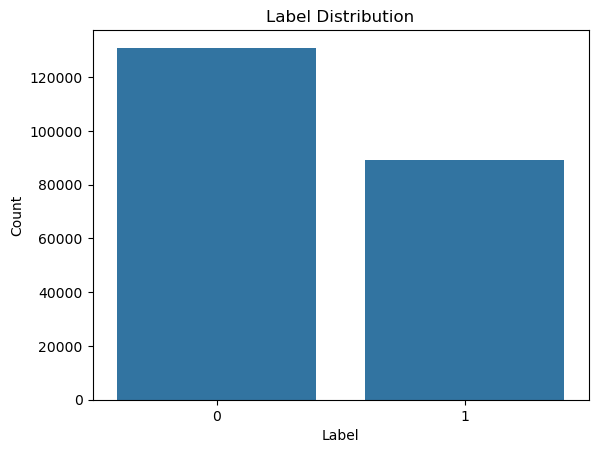

In [5]:
# inspect the number of images for each label   
label_counts = train_df['label'].value_counts()
print(label_counts)
print(f'Percentage of positive cases: {label_counts[1] / label_counts.sum() * 100:.2f}%')
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [18]:
# function of displaying random images
def random_images_display(df, folder_path, n_images, label=None):
    plt.figure(figsize=(10, 5))
    if label is not None:
        images = df[df['label'] == label].sample(n_images)
    else:
        images = df.sample(n_images)
        
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        img_path = f'{folder_path}/{images.iloc[i]["id"]}.tif'
        img = plt.imread(img_path)
        plt.imshow(img)
        if label is not None:
            plt.title(images.iloc[i]['label'])
        plt.axis('off')
    plt.show()

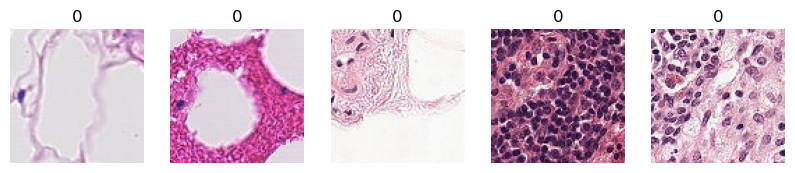

In [27]:
# display 5 random images with label 0
random_images_display(train_df, 'data/train', 5, '0')

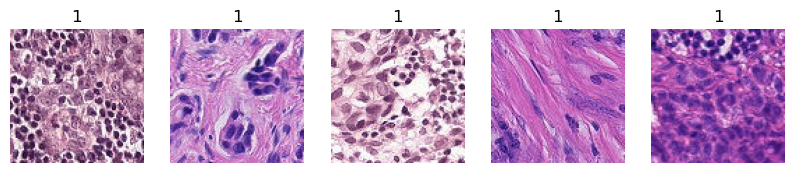

In [28]:
# display 5 random images with label 1
random_images_display(train_df, 'data/train', 5, '1')

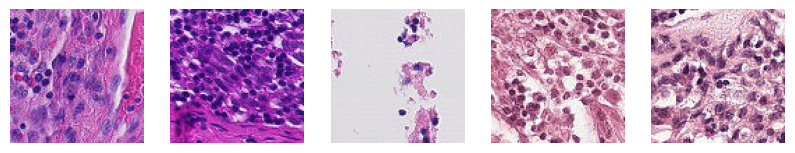

In [36]:
# display 5 random images from the test folder
random_images_display(test_df, 'data/test', 5)

## Data Processing

The **ImageDataGenerator** is a tool in the TensorFlow and Keras frameworks for image data augmentation and preprocessing. It allows for the batch reading of image data from files while applying a range of random transformations (such as rotation, flipping, scaling, etc.) in real-time, thus enlarging the training set without additional storage requirements. This is particularly useful for preventing overfitting and improving the model's generalization ability on new data. 

In [37]:
# split the train data into train and validation sets
train, val = train_test_split(train_df, stratify=train_df['label'], test_size=0.2, random_state=SEED)

# create a data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    rotation_range=90,
                                    zoom_range=0.2,
                                    #  width_shift_range=0.1,
                                    #  height_shift_range=0.1,
                                    #  shear_range=0.05,
                                    #  channel_shift_range=0.1
                                    )
# val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# create a train generator
train_generator = train_datagen.flow_from_dataframe(train,
                                                    x_col='img_path',
                                                    y_col='label',
                                                    target_size=(96, 96),
                                                    batch_size=32,
                                                    class_mode='binary')

# create a validation generator
val_generator = test_datagen.flow_from_dataframe(val,
                                                x_col='img_path',
                                                y_col='label',
                                                target_size=(96, 96),
                                                batch_size=32,
                                                class_mode='binary')

# create a test generator
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                x_col='img_path',
                                                target_size=(96, 96),
                                                batch_size=32,
                                                class_mode=None,
                                                shuffle=False)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


## Models

**Convolutional Neural Networks (CNNs)** are a type of deep learning architecture particularly suited for processing grid-structured data, such as images. It extract features from images, ranging from low-level to high-level, by alternately stacking convolutional and pooling layers. After several convolutional and pooling layers, the extracted features are utilized in fully connected layers for final classification or other tasks.

The fellowing are the CNNs models used.

In [79]:
def simple_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model


def cnn_with_dropout(dropout_rate=0.3):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),  
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate), 
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model


def cnn_with_bn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model


# ResNet: Residual Network
def resnet_cnn(): 
    inputs = Input(shape=(96, 96, 3))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Residual Block 1
    y = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    y = BatchNormalization()(y)
    y = Conv2D(64, (3, 3), activation='relu', padding='same')(y)
    y = BatchNormalization()(y)
    y = Add()([x, y])
    y = MaxPooling2D((2, 2))(y)

    # Residual Block 2
    z = Conv2D(64, (3, 3), activation='relu', padding='same')(y)
    z = BatchNormalization()(z)
    z = Conv2D(64, (3, 3), activation='relu', padding='same')(z)
    z = BatchNormalization()(z)
    z = Add()([y, z])
    z = MaxPooling2D((2, 2))(z)

    # Fully Connected Layers
    z = Flatten()(z)
    z = Dense(128, activation='relu')(z)
    z = Dropout(0.3)(z)
    outputs = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def modified_resnet(): 
    inputs = Input(shape=(96, 96, 3))
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    y = Conv2D(64, (3, 3), padding='same')(x)
    y = BatchNormalization()(y)
    x = Activation('relu')(x)
    y = Conv2D(64, (3, 3), activation='relu', padding='same')(y)
    y = Add()([x, y])
    y = MaxPooling2D((2, 2))(y)
    y = Dropout(0.3)(y)

    z = Conv2D(64, (3, 3), padding='same')(y)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = Conv2D(64, (3, 3), activation='relu', padding='same')(z)
    z = Add()([y, z])
    z = MaxPooling2D((2, 2))(z)
    z = Dropout(0.3)(z)

    z = Flatten()(z)
    z = Dense(128, activation='relu')(z)
    z = Dropout(0.3)(z)
    outputs = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [39]:
# function of displaying the auc and loss of the model
def auc_loss_history(history):
    acc = history.history['auc']
    val_acc = history.history['val_auc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training AUC')
    plt.plot(val_acc, label='Validation AUC')
    plt.legend()
    plt.title('Training and Validation AUC')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [68]:
N_TRAIN = train_generator.n
N_VAL = val_generator.n
EPOCHS = 15
BATCH_SIZE = 32
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
STEPS_PER_EPOCH_VAL = N_VAL // BATCH_SIZE

y_train = train['label'].astype(int)
# weights = {0: 1/np.sum(y_train==0), 1: 1/np.sum(y_train==1)}

def train_and_predict(model_function, model_name):

    history = None

    model = model_function()
    
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*5,
    decay_rate=1,
    staircase=False)

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule, name='Adam')
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC(name='auc'), 'accuracy'])

    print(model.summary())
    
    early_stopping = EarlyStopping(
        monitor='val_loss',   
        # monitor='val_auc',     
        patience=3,
        restore_best_weights=True 
    )
    
    model_checkpoint = ModelCheckpoint(f'models/{model_name}.h5', save_best_only=True)

    history= model.fit(train_generator,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data=val_generator,
                        validation_steps=STEPS_PER_EPOCH_VAL,
                        epochs=EPOCHS,
                        # class_weight=weights,
                        callbacks=[early_stopping, model_checkpoint], 
                        verbose=1)

    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'history/{model_name}.csv', index=False)
    
    auc_loss_history(history)
    
    y_pred_proba = model.predict(test_generator)
    
    # save the predicted probabilities to a csv file
    submission_df = test_df.copy()
    submission_df.drop('img_path', axis=1, inplace=True)
    submission_df['label'] = y_pred_proba
    submission_df.to_csv(f'predictions/{model_name}.csv', index=False)
    


## Simple CNN

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 10, 10, 64)      

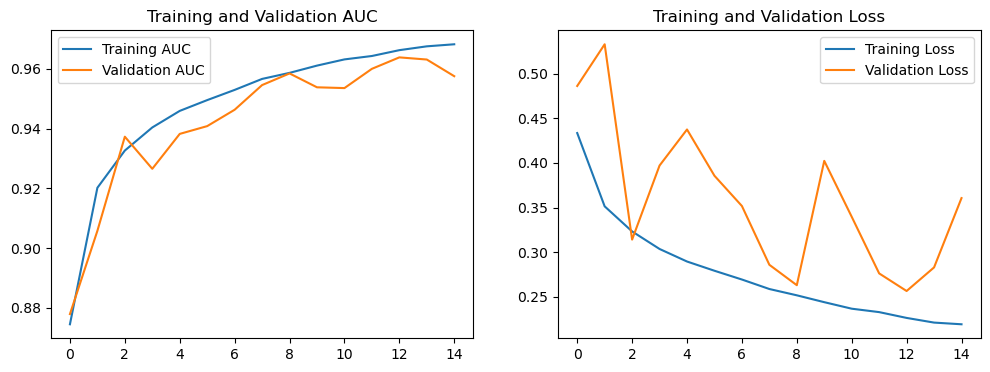

1796/1796 [==============================] - 74s 41ms/step


In [69]:
train_and_predict(simple_cnn, 'simple_cnn_2')

The fluctuations in the validation curves could suggest that the learning rate is too high, which prevents the model from stabilizing during the learning process. Considering a reduction in the learning rate might help in reducing these fluctuations.

The simple cnn model obtained the test private/public score:

<img src='pics/score_simple_cnn_2.png' width=500>

## CNN with dropout

**Dropout** is a technique to prevent overfitting in deep learning models. During training, it randomly drops the outputs of a portion of neurons within the network. This reduces complex co-adaptations between neurons.


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 47, 47, 32)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 22, 22, 64)      

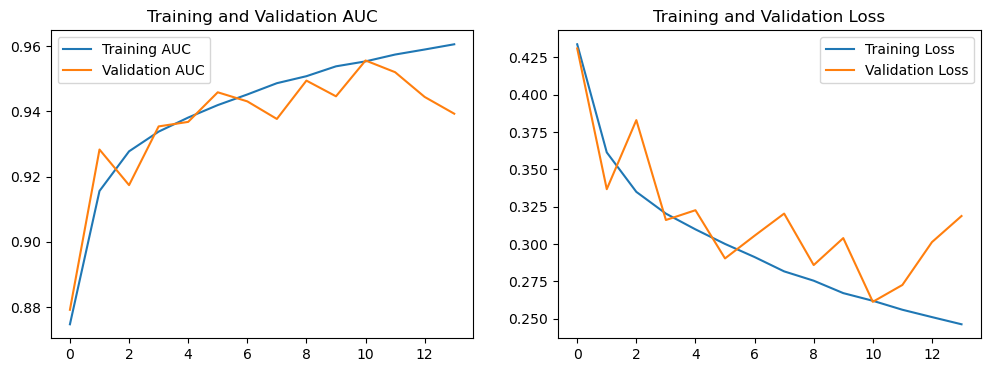

1796/1796 [==============================] - 72s 40ms/step


In [70]:
train_and_predict(cnn_with_dropout, 'cnn_with_dropout_2')

The cnn model with dropout obtained the test private/public score:

<img src='pics/score_cnn_with_dropout_2.png' width=500>

## CNN with Batch Normalization

**Batch Normalization** is a technique for accelerating deep neural network training and improving performance. It normalizes the data for each mini-batch, adjusting and scaling the data to maintain stability throughout the model's learning process. This helps to mitigate internal covariate shift problem.

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 94, 94, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 45, 45, 64)        256       
 chNormalization)                                                
                                                     

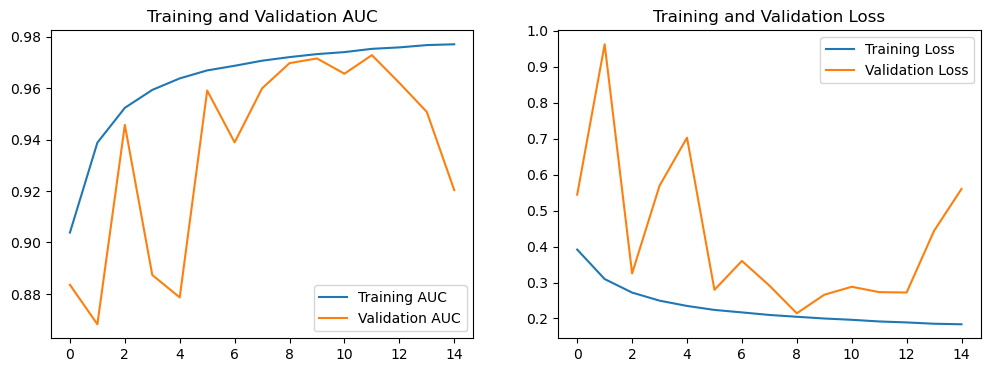

1796/1796 [==============================] - 116s 64ms/step


In [71]:
train_and_predict(cnn_with_bn, 'cnn_with_bn_2')

The cnn model with batch normalization obtained the test private/public score:

<img src='pics/score_cnn_with_bn_2.png' width=500>

## ResNet

**Residual Network (ResNet)** addresses the vanishing and exploding gradients problem in deep networks through residual blocks. Each residual block allows the input to skip one or more layers, merging with the output of those layers before the addition operation.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_50 (Conv2D)          (None, 96, 96, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_11 (Ba  (None, 96, 96, 64)           256       ['conv2d_50[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_48 (MaxPooli  (None, 48, 48, 64)           0         ['batch_normalization_11

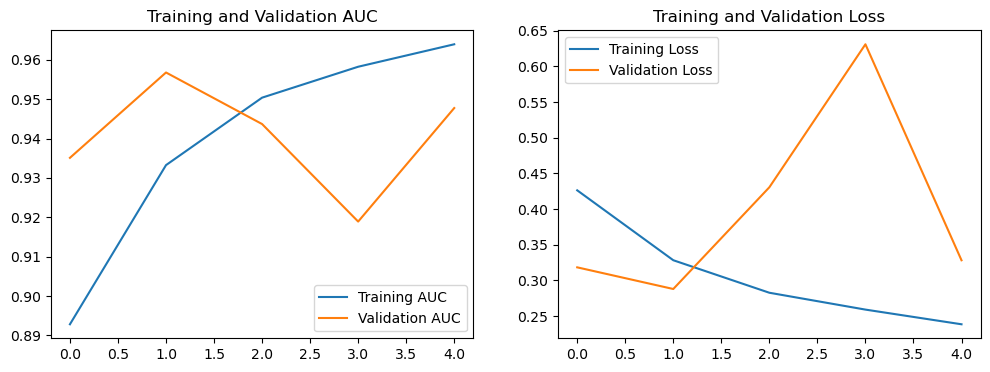

1796/1796 [==============================] - 242s 134ms/step


In [72]:
train_and_predict(resnet_cnn, 'resnet_cnn_2')

The ResNet model obtained the test private/public score:

<img src='pics/score_resnet_cnn_2.png' width=500>

## Modified ResNet

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_85 (Conv2D)          (None, 48, 48, 64)           1792      ['input_7[0][0]']             
                                                                                                  
 batch_normalization_44 (Ba  (None, 48, 48, 64)           256       ['conv2d_85[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_25 (Activation)  (None, 48, 48, 64)           0         ['batch_normalization_44

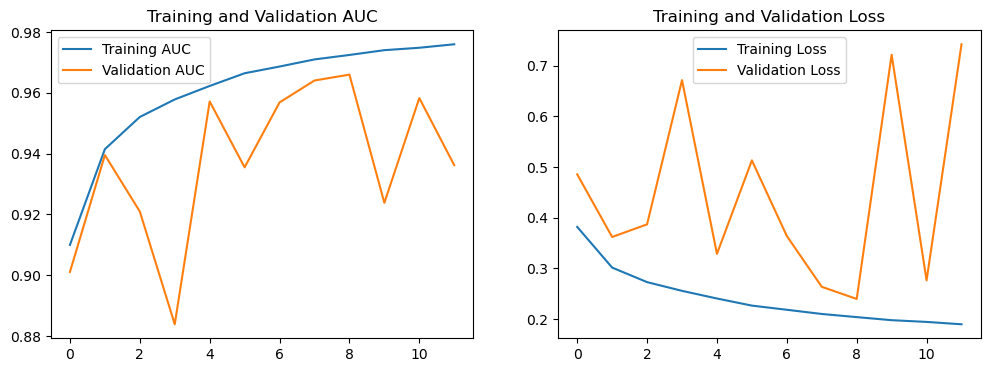

1796/1796 [==============================] - 107s 59ms/step


In [81]:
train_and_predict(modified_resnet, 'modified_resnet_2')

The observation from the above graphs indicates that the model may be overfitting, as the training auc is consistently higher than the validation auc, and the training loss is consistently lower than the validation loss. Attempting to add more regularization may help reduce overfitting.

The modified ResNet model obtained the test private/public score:

<img src='pics/score_modified_resnet_2.png' width=500>

## Hyperparameter Tuning

Here Optuna is used to tune hyperparameters such as the learning rate, dropout rate, batch size.

In [6]:
def objective(trial):
    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    model = cnn_with_dropout(dropout_rate=dropout_rate)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC(name='auc')])
    print(model.summary())
    
    early_stopping = EarlyStopping(
        # monitor='val_loss',   
        monitor='val_auc',     
        patience=3,
        restore_best_weights=True 
    )
    
    history= model.fit(train_generator,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data=val_generator,
                        validation_steps=STEPS_PER_EPOCH_VAL,
                        epochs=EPOCHS,
                        # class_weight=weights,
                        callbacks=[early_stopping], 
                        batch_size=batch_size,
                        verbose=1)
    
    return np.mean(history.history['val_auc'])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)


In [ ]:
best_params = study.best_params
best_learning_rate = best_params['learning_rate']
best_dropout_rate = best_params['dropout_rate']
best_batch_size = best_params['batch_size']

final_model = cnn_with_dropout(best_dropout_rate)
final_optimizer = Adam(learning_rate=best_learning_rate)
final_model.compile(loss='binary_crossentropy', optimizer=final_optimizer, metrics=[AUC(name='auc')])

early_stopping = EarlyStopping(
    monitor='val_loss',   
    # monitor='val_auc',     
    patience=3,
    restore_best_weights=True 
)

model_checkpoint = ModelCheckpoint('models/final_model.h5', save_best_only=True)

final_history = final_model.fit(train_generator,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data=val_generator,
                        validation_steps=STEPS_PER_EPOCH_VAL,
                        epochs=EPOCHS,
                        # class_weight=weights,
                        callbacks=[early_stopping, model_checkpoint], 
                        batch_size=best_batch_size,
                        verbose=1)



Epoch 1/10
5500/5500 [==============================] - 921s 167ms/step - loss: 5.5904e-06 - auc: 0.8436 - val_loss: 0.4529 - val_auc: 0.8747
Epoch 2/10
5500/5500 [==============================] - 906s 165ms/step - loss: 4.8071e-06 - auc: 0.8876 - val_loss: 0.4001 - val_auc: 0.9166
Epoch 3/10
5500/5500 [==============================] - 904s 164ms/step - loss: 4.0998e-06 - auc: 0.9198 - val_loss: 0.3360 - val_auc: 0.9308
Epoch 4/10
5500/5500 [==============================] - 907s 165ms/step - loss: 3.8502e-06 - auc: 0.9295 - val_loss: 0.3056 - val_auc: 0.9389
Epoch 5/10
5500/5500 [==============================] - 893s 162ms/step - loss: 3.7033e-06 - auc: 0.9349 - val_loss: 0.3351 - val_auc: 0.9353
Epoch 6/10
5500/5500 [==============================] - 891s 162ms/step - loss: 3.5899e-06 - auc: 0.9389 - val_loss: 0.2860 - val_auc: 0.9468
Epoch 7/10
5500/5500 [==============================] - 879s 160ms/step - loss: 3.4761e-06 - auc: 0.9427 - val_loss: 0.2909 - val_auc: 0.9453
Epoch 

In [ ]:
best_params

# cnn with dropout 
# {'learning_rate': 0.0037515025196294765,
#  'dropout_rate': 0.14381995493012711,
#  'batch_size': 64}

{'learning_rate': 0.0037515025196294765,
 'dropout_rate': 0.14381995493012711,
 'batch_size': 64}

In [ ]:
his_cnn_dropout_tuned_df = pd.DataFrame(final_history.history)
his_cnn_dropout_tuned_df.to_csv('history/his_cnn_dropout_tuned.csv', index=False)

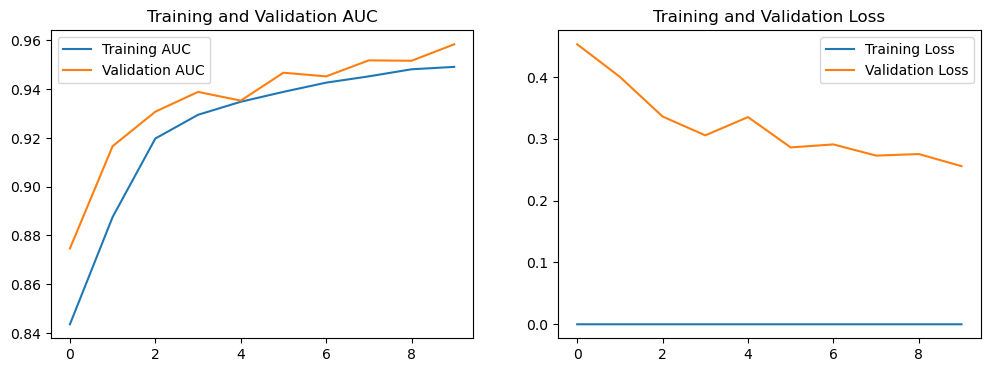

In [ ]:
auc_loss_history(final_history)

The AUC values gradually increase as training progresses, indicating an improvement in the model's performance. The validation AUC is close to, and even slightly exceeds the training AUC, suggesting that the model generalizes well to unseen data.

Both the training and validation losses decrease over time. The decline in validation loss is gradual, and its values are significantly higher than those of the training loss, which may imply that the model is still learning.

In [ ]:
pred_proba = final_model.predict(test_generator)

test_df['label'] = pred_proba
test_df.head()


1796/1796 [==============================] - 80s 44ms/step


,id,label,img_path
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.043716,data/test/0b2ea2a822ad23fdb1b5dd26653da899fbd2...
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.205786,data/test/95596b92e5066c5c52466c90b69ff089b39f...
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.014869,data/test/248e6738860e2ebcf6258cdc1f32f299e0c7...
3,2c35657e312966e9294eac6841726ff3a748febf,0.127190,data/test/2c35657e312966e9294eac6841726ff3a748...
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.154135,data/test/145782eb7caa1c516acbe2eda34d9a3f31c4...


In [ ]:
sub_df = test_df.drop('img_path', axis=1)
sub_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.043716
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.205786
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.014869
3,2c35657e312966e9294eac6841726ff3a748febf,0.127190
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.154135


In [ ]:
sub_df.to_csv('predictions/cnn_dropout_tuned.csv', index=False)

The tuned cnn model with dropout obtained the test private/public score:

<img src='pics/score_cnn_dropout_tuned.png' width=500>

## Summary

| Model               | Private Score    | Public Score     |
|---------------------|------------------|------------------|
| simple_cnn        | 0.8397           | 0.9118           |
| cnn_with_dropout  | 0.8944           | 0.9290           |
| cnn_with_bn       | 0.8623           | 0.9065           |
| resnet_cnn        | 0.8849           | 0.9115           |
| modified_resnet   | 0.8731           | 0.9453           |
| cnn_dropout_tuned   | 0.9179           | 0.9401           |

<br>

- The models exhibit a lower performance on the private scores compared to the public scores, which may indicate that the models are overfitting the training data and not generalizing well to unseen data.

- The simple cnn model shows a good performance on the public score, but there is a significant drop when compared to the private score. After the introduction of dropout or batch normalization, an improvement in private score can be observed. The ResNet model shows a good overall performance, and the modified ResNet with regularization achieves a public score of 0.9453. The tuned cnn model with dropout obtains a private score of 0.9179 and a public score of 0.9401.

<br>

### Directions for Improvement

- Increase training data diversity through data augmentation. 

- Use cross-validation to more reliably evaluate model generalization.

- Conduct a broader hyperparameter search to find the most optimized model configuration.

- Adjust the model's complexity to ensure the model is neither overfitting nor underfitting.

- Combine predictions from multiple models to increase performance and stability.
